In [2]:
import os
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from random import shuffle
import random

from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, Input, Dense, Concatenate, Reshape, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


In [3]:
SIZE = 200
CHANNELS = 3
EPOCHS = 5
BATCH_SIZE = 128

In [4]:
PATH = '../input/cats-vs-dogs/train/'

In [5]:
def get_input(file):
    return Image.open(PATH+file)
def get_output(file):
    class_label = file.split('.')[0]
    if class_label == 'dog': label_vector = [1,0]
    elif class_label == 'cat': label_vector = [0,1]
    return label_vector

In [6]:
def preprocess_input(image):
    
    # Data preprocessing
    image = image.resize((SIZE,SIZE))
    image = np.array(image).reshape(SIZE,SIZE,CHANNELS)
    
    # Normalize image
    
    image = image/255.0
    
    
    return image

In [7]:
def custom_image_generator(images, batch_size = 128):
    
    while True:
        # Randomly select images for the batch
        batch_images = np.random.choice(images, size = batch_size)
        batch_input = []
        batch_output = [] 
        
        # Read image, perform preprocessing and get labels
        for file in batch_images:
            # Function that reads and returns the image
            input_image = get_input(file)
            # Function that gets the label of the image
            label = get_output(file)
            # Function that pre-processes and augments the image
            image = preprocess_input(input_image)

            batch_input.append(image)
            batch_output.append(label)

        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        # Return a tuple of (images,labels) to feed the network
        yield(batch_x, batch_y)


In [8]:
def get_label(file):
    class_label = file.split('.')[0]
    if class_label == 'dog': label_vector = [1,0]
    elif class_label == 'cat': label_vector = [0,1]
    return label_vector

In [9]:
def get_data(files):
    data_image = []
    labels = []
    for image in tqdm(files):
        
        label_vector = get_label(image)
        

        img = Image.open(PATH + image)
        img = img.resize((SIZE,SIZE))
        
       
        labels.append(label_vector)
        img = np.asarray(img).reshape(SIZE,SIZE,CHANNELS)
        img = img/255.0
        data_image.append(img)
        
    data_x = np.array(data_image)
    data_y = np.array(labels)
        
    return (data_x, data_y)

In [10]:
files = os.listdir(PATH)

In [11]:
random.shuffle(files)
train = files[:7000]
test = files[7000:]

In [12]:
validation_data = get_data(test)

100%|██████████| 3000/3000 [00:13<00:00, 227.17it/s]


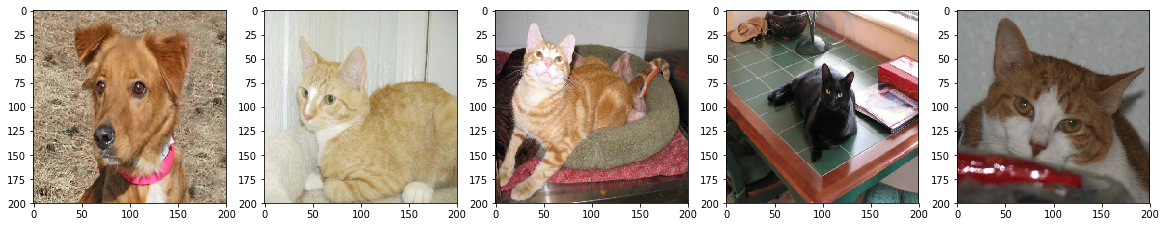

In [13]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(validation_data[0][i])

In [14]:
from keras import backend as K
K.set_image_data_format('channels_last')

In [15]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(200,200,3))

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 3s 0us/step


In [16]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 99, 99, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 99, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
keep_prob = 0.5
x = Dropout(rate = 1 - keep_prob)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 99, 99, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 99, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [19]:
print('Trainable weights before freezing the transferred layers:', len(model.trainable_weights))
for layer in base_model.layers:
    layer.trainable = False
print('Trainable weights after freezing the transferred layers:', len(model.trainable_weights))

Trainable weights before freezing the transferred layers: 192
Trainable weights after freezing the transferred layers: 4


In [20]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics = ['accuracy'])

In [21]:
model_details = model.fit_generator(custom_image_generator(train, batch_size = BATCH_SIZE),
                    steps_per_epoch = len(train) // BATCH_SIZE, 
                    epochs = EPOCHS, 
                    validation_data= validation_data,
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
54/54 [==============================] - 50s 931ms/step - loss: 0.3433 - acc: 0.8468 - val_loss: 0.0780 - val_acc: 0.9797
Epoch 2/5
54/54 [==============================] - 37s 683ms/step - loss: 0.2299 - acc: 0.9023 - val_loss: 0.0756 - val_acc: 0.9787
Epoch 3/5
54/54 [==============================] - 39s 721ms/step - loss: 0.1720 - acc: 0.9291 - val_loss: 0.0822 - val_acc: 0.9783
Epoch 4/5
54/54 [==============================] - 39s 714ms/step - loss: 0.1571 - acc: 0.9372 - val_loss: 0.1204 - val_acc: 0.9783
Epoch 5/5
54/54 [==============================] - 39s 715ms/step - loss: 0.1567 - acc: 0.9339 - val_loss: 0.0939 - val_acc: 0.9783


In [22]:
score = model.evaluate(validation_data[0], validation_data[1])

3000/3000 [==============================] - 7s 2ms/step


In [23]:
print("Accuracy: {0:.2f}%".format(score[1]*100))

Accuracy: 97.83%


In [24]:
y_pred = model.predict(validation_data[0])

In [25]:
correct_indices = np.nonzero(np.argmax(y_pred,axis=1) == np.argmax(validation_data[1],axis=1))[0]
incorrect_indices = np.nonzero(np.argmax(y_pred,axis=1) != np.argmax(validation_data[1],axis=1))[0]

In [26]:
labels = ['dog', 'cat']

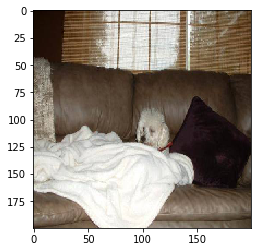

Prediction: cat


In [27]:
image = 5
plt.imshow(validation_data[0][incorrect_indices[image]].reshape(SIZE, SIZE, CHANNELS),  cmap=plt.get_cmap('gray'))
plt.show()
print("Prediction: {0}".format(labels[np.argmax(y_pred[incorrect_indices[image]])]))

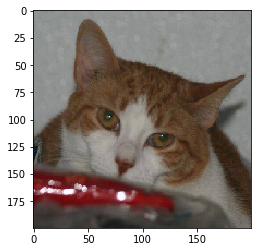

Prediction: cat


In [28]:
image = 4
plt.imshow(validation_data[0][correct_indices[image]].reshape(SIZE, SIZE, CHANNELS), cmap=plt.get_cmap('gray'))
plt.show()
print("Prediction: {0}".format(labels[np.argmax(y_pred[correct_indices[image]])]))